In [91]:
import dm_den
import dm_den_viz
import pickle
import numpy as np
import pandas as pd
from importlib import reload

import matplotlib as mpl
from matplotlib import pyplot as plt

from lmfit import minimize, Parameters
from astropy import units as u

import scipy
#from scipy.stats.stats import pearsonr
from scipy import integrate

# $P(v)$

## Getting started

In [2]:
with open('./data/v_pdfs.pkl','rb') as f:
    pdfs_v=pickle.load(f)
vs_pdfs=np.array([pdfs_v[galname]['bins'] 
                  for galname in pdfs_v]).flatten()
vs_shm=np.linspace(vs_pdfs.min(), vs_pdfs.max(), 70)

In [3]:
def shm(vmag, sigma=200.*u.km/u.s / np.sqrt(2.)):
    vmag*=u.km/u.s
    f = 1. / (2.*np.pi*sigma**2.)**(3./2.) * np.exp(-(vmag)**2. / (2.*sigma**2.))
    f = (3. / (2.*np.pi*sigma**2.))**(3./2.) * np.exp(-3.*vmag**2. / (2.*sigma**2.))
    p = f*vmag**2.*4.*np.pi
    return p.to(u.s/u.km).value

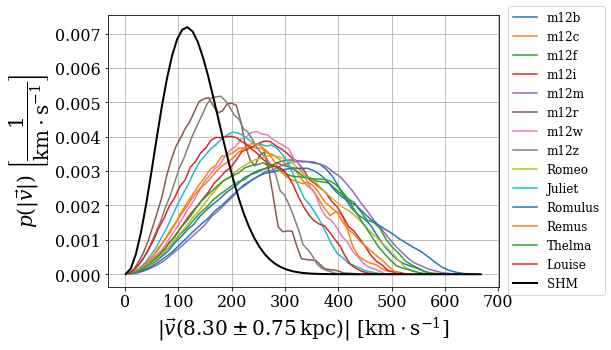

In [4]:
def plt_nonnorm():
    fig=plt.figure(figsize=(7,5))
    ax=fig.add_subplot(111)
    for galname in pdfs_v:
        bins=pdfs_v[galname]['bins']
        midbins=(bins[1:]+bins[:-1])/2.
        ax.plot(midbins,pdfs_v[galname]['ps'],label=galname)
    ax.set_xlabel('$|\\vec{v}(8.30\pm0.75\,\mathrm{kpc})|\ [\mathrm{km}\cdot\mathrm{s}^{-1}]$')
    ax.set_ylabel('$p(|\\vec{v}|)\ \\left[\dfrac{1}{\mathrm{km}\cdot\mathrm{s}^{-1}}\\right]$')
    ax.plot(vs_shm,shm(vs_shm),'k-',lw=2, label='SHM')
    ax.legend(fontsize=12.,bbox_to_anchor=(1.01,0.5),
              loc='center left')
    fig.patch.set_facecolor('white')
    plt.show()
    return None
plt_nonnorm()

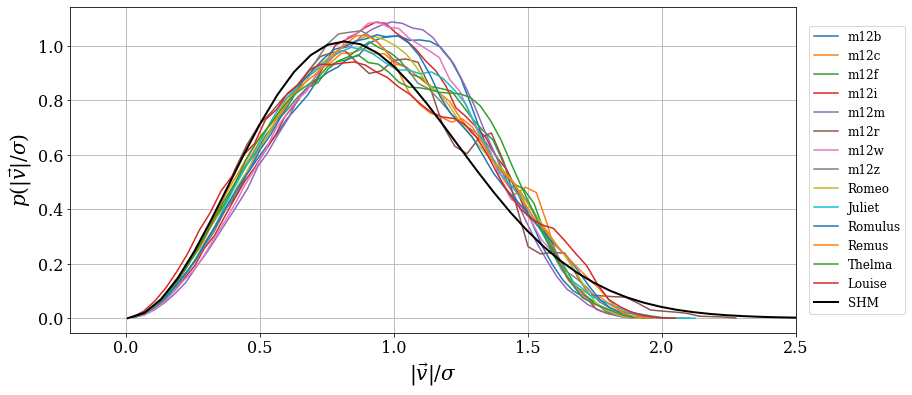

In [5]:
def plt_norm():
    fig=plt.figure(figsize=(13,6))
    ax=fig.add_subplot(111)
    for galname in pdfs_v:
        sigma=dm_den.load_data('dm_den_20210804_2.h5').loc[galname,'disp_solar']
        bins=pdfs_v[galname]['bins']
        midbins=(bins[1:]+bins[:-1])/2.
        ax.plot(midbins/sigma, pdfs_v[galname]['ps']*sigma, label=galname)
    ax.set_xlabel('$|\\vec{v}|/\sigma$')
    ax.set_ylabel('$p(|\\vec{v}| / \sigma)$')
    
    sigma_shm=220.*u.km/u.s / np.sqrt(2.)
    ax.plot(vs_shm/sigma_shm, shm(vs_shm, sigma_shm)*sigma_shm, 'k-',lw=2, label='SHM')
    ax.legend(fontsize=12.,bbox_to_anchor=(1.01,0.5),
              loc='center left')
    fig.patch.set_facecolor('white')
    ax.set_xlim(None,2.5)
    plt.show()
    return None
plt_norm()

## Trying non-Maxwellian fit

### $p(\xi)\mathrm{d}\xi=\dfrac{4\pi\xi^2}{N}\exp\left[-\left(\dfrac{\xi^2}{\xi_0^2}\right)^\alpha\right]\mathrm{d}\xi$
### $\xi=\dfrac{|\vec{v}|}{\sigma_\mathrm{3D}}$
### $N=\frac{4}{3}\pi\xi_0^3\Gamma\left(1+\dfrac{3}{2\alpha}\right)$
### $\displaystyle\int_0^\infty p(\xi)\mathrm{d}\xi = 1$

### Defining distribution functions

In [66]:
def gen_max(v,v0,a):
    f = 4.*np.pi*v**2.*np.exp(-(v/v0)**(2.*a))
    N = 4./3.*np.pi * v0**3. * scipy.special.gamma(1.+3./(2.*a))
    return f / N

def gen_gauss(x,mu,x0,a):
    y=-(((x-mu)/x0)**2.)**a
    f = np.exp(y)
    N = 2.*x0*scipy.special.gamma(1.+1./2./a)
    '''print(mu)
    print(x0)
    print('alpha={0:0.20f}'.format(a))'''
    return f/N

def trunc_max(v,v0,a,vesc):
    f = v**2.*np.exp(-(v/v0)**(2.*a))
    g1 = scipy.special.gamma(3./2./a)
    g2 = scipy.special.gammainc((v0/vesc)**(-2.*a),3./2./a)
    N = v0**3./2./a * (g1 - g2)
    p = f/N
    
    if isinstance(v,(list,np.ndarray)):
        isesc = v>=vesc
        p[isesc] = 0.
    else:
        if v>=vesc:
            return 0.
    return p

def exp_trunc_max(v,v0,a,vesc):
    def f(v,v0,a,vesc):
        return v**2.*np.exp(-(v/v0)**(2.*a)) / (1.+np.exp(-(vesc-v)/v0/0.3))
    N = scipy.integrate.quad(f,0.,np.inf,(v0,a,vesc))[0]
    return f(v,v0,a,vesc) / N

### Defining fitting methods

In [ ]:
def fit_gal(galname, ax):
    sigma=dm_den.load_data('dm_den_20210804_2.h5').loc[galname,'disp_solar']
    bins=pdfs_v[galname]['bins']
    midbins=(bins[1:]+bins[:-1])/2.
    xs=midbins/sigma
    w=np.average(xs[1:]-xs[:-1])
    ys=pdfs_v[galname]['ps']*sigma
    
    res_gen, _ = scipy.optimize.curve_fit(gen_max, xs, ys)
    v0_gen, a_gen = res_gen
    ys_fit_gen = gen_max(xs,v0_gen,a_gen)
    sse_gen = np.sum((ys-ys_fit_gen)**2.)
    sser_gen=sse_gen/(xs.size-len(res_gen))
    
    maxwell = lambda xs,v0: gen_max(xs,v0,1.)
    res, _ = scipy.optimize.curve_fit(maxwell, xs, ys)
    v0 = res[0]
    ys_fit = maxwell(xs,v0)
    sse_1=np.sum((ys-ys_fit)**2.)
    sser_1=sse_1/(xs.size-len(res))
    
    #ax.bar(xs,ys,ec='white',width=w)
    ax.step(xs,ys,'k',where='mid',color='grey')
    ax.plot(xs,ys_fit_gen,'-',color='b')
    ax.plot(xs,ys_fit,'-',color='red')
    
    loc=[0.97,0.96]
    
    kwargs_txt = dict(fontsize=12., xycoords='axes fraction',
                  va='top', ha='right', 
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax.annotate(galname,loc,
                **kwargs_txt)
    txt_gen = '$x_0={0:0.3f};$\n$\\alpha={1:0.2f};$\n$\mathrm{{SSE}}_\mathrm{{r}}={2:0.1e}$'.format(v0_gen,a_gen,sser_gen)
    inv = ax.transAxes.inverted()
    loc=ax.transAxes.transform(loc)
    loc[1]-=15.
    loc=inv.transform(loc)
    ax.annotate(txt_gen, loc, color='b',
                **kwargs_txt)
    txt_1 = '$x_0={0:0.3f};$\n$\\alpha=1;$\n$\mathrm{{SSE}}_\mathrm{{r}}={1:0.1e}$'.format(v0,sser_1)
    loc=ax.transAxes.transform(loc)
    loc[1]-=60.
    loc=inv.transform(loc)
    ax.annotate(txt_1, loc,
                color='r',
                **kwargs_txt)
    
    return None

In [67]:
def fit_trunc_gal(galname, ax, trunc_max=trunc_max):
    sigma=dm_den.load_data('dm_den_20210804_2.h5').loc[galname,'disp_solar']
    bins=pdfs_v[galname]['bins']
    midbins=(bins[1:]+bins[:-1])/2.
    xs=midbins/sigma
    w=np.average(xs[1:]-xs[:-1])
    ys=pdfs_v[galname]['ps']*sigma
    
    res_gen, _ = scipy.optimize.curve_fit(trunc_max, xs, ys)
    v0_gen, a_gen, vesc_gen = res_gen
    ys_fit_gen = trunc_max(xs,*res_gen)
    sse_gen = np.sum((ys-ys_fit_gen)**2.)
    sser_gen=sse_gen/(xs.size-len(res_gen))
    
    maxwell = lambda xs,v0: gen_max(xs,v0,1.)
    res, _ = scipy.optimize.curve_fit(maxwell, xs, ys)
    v0 = res[0]
    ys_fit = maxwell(xs,v0)
    sse_1=np.sum((ys-ys_fit)**2.)
    sser_1=sse_1/(xs.size-len(res))
    
    #ax.bar(xs,ys,ec='white',width=w)
    ax.step(xs,ys,'k',where='mid',color='grey')
    ax.plot(xs,ys_fit_gen,'-',color='b')
    ax.plot(xs,ys_fit,'-',color='red')
    
    loc=[0.97,0.96]
    
    kwargs_txt = dict(fontsize=12., xycoords='axes fraction',
                  va='top', ha='right', 
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax.annotate(galname,loc,
                **kwargs_txt)
    txt_gen = '$x_0={0:0.3f};$\n$\\alpha={1:0.2f};$\n'\
              '$\mathrm{{SSE}}_\mathrm{{r}}={2:0.1e}$\n'\
              '$x_\mathrm{{esc}}={3:0.1f}$'.format(v0_gen,a_gen,sser_gen,vesc_gen)
    inv = ax.transAxes.inverted()
    loc=ax.transAxes.transform(loc)
    loc[1]-=15.
    loc=inv.transform(loc)
    ax.annotate(txt_gen, loc, color='b',
                **kwargs_txt)
    txt_1 = '$x_0={0:0.3f};$\n$\\alpha=1;$\n$\mathrm{{SSE}}_\mathrm{{r}}={1:0.1e}$'.format(v0,sser_1)
    loc=ax.transAxes.transform(loc)
    loc[1]-=75.
    loc=inv.transform(loc)
    ax.annotate(txt_1, loc,
                color='r',
                **kwargs_txt)
    
    return None

### $p\left(\dfrac{|\vec{v}|}{\sigma_\mathrm{3D}}\right)$

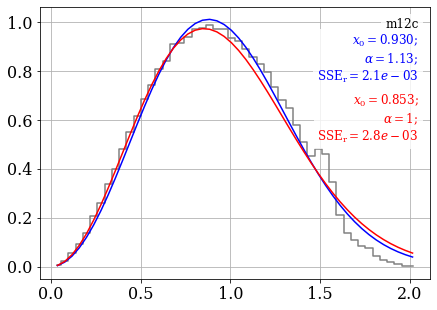

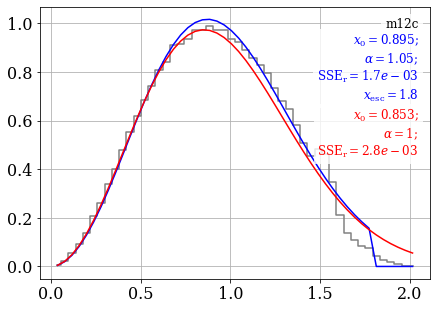

/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


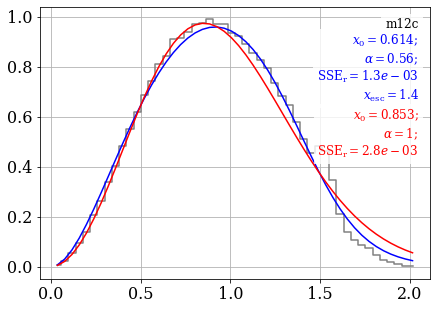

In [68]:
gal='m12c'

fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
fit_gal(gal,ax)
xs_test=np.linspace(0.,2.,100)
plt.show()

fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
fit_trunc_gal(gal,ax, trunc_max)
plt.show()

fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
fit_trunc_gal(gal,ax, exp_trunc_max)
plt.show()

[]

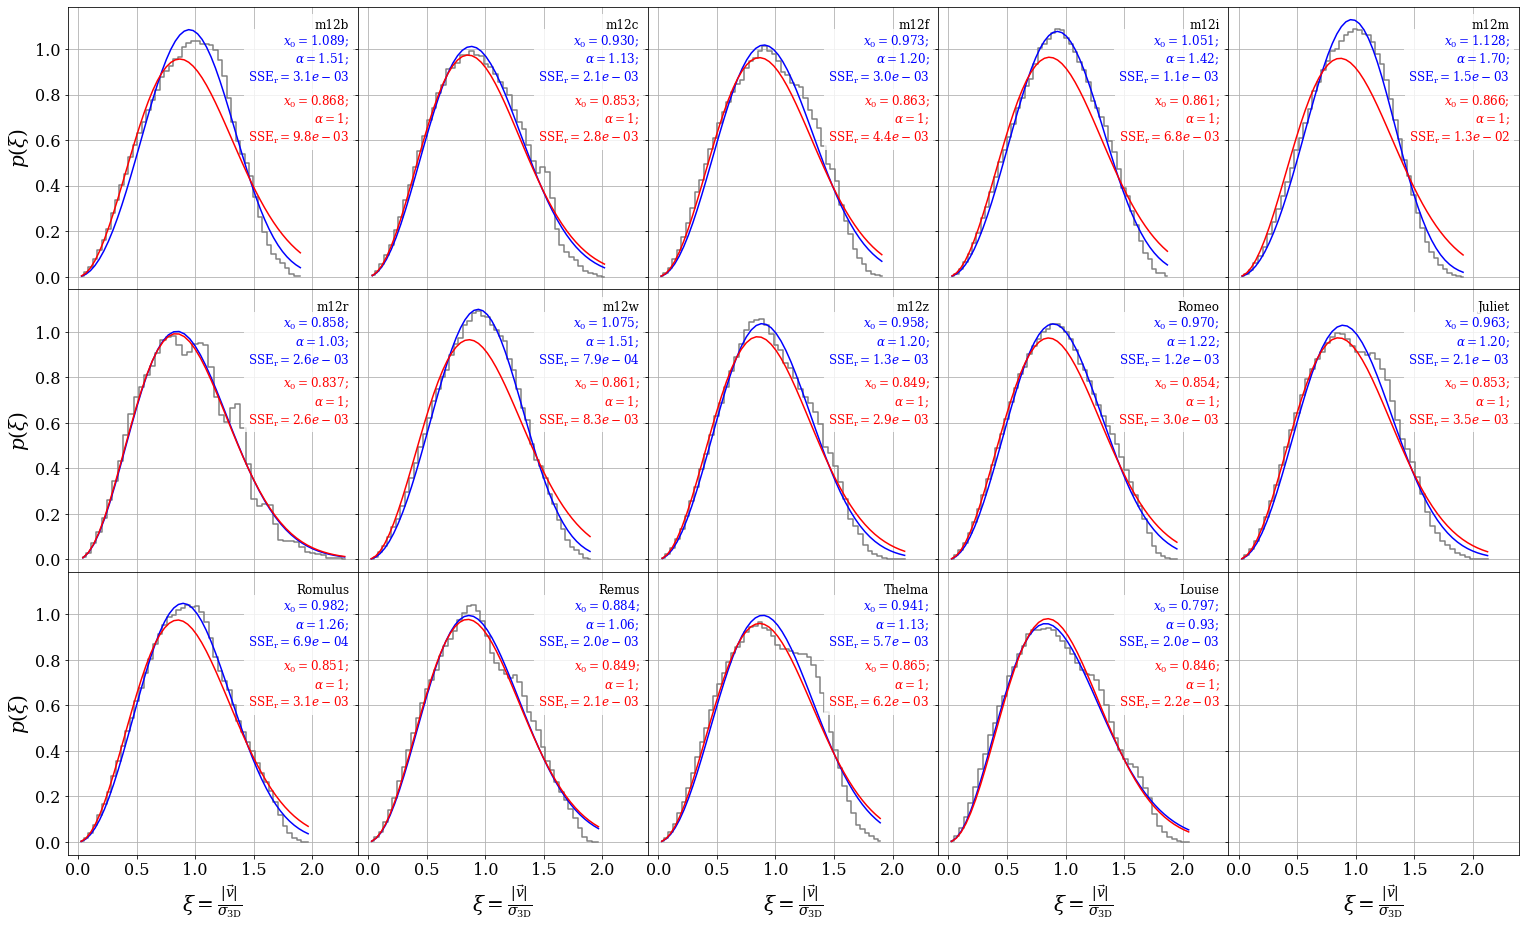

In [88]:
df=dm_den.load_data('dm_den_20210804_2.h5')
fig,axs=plt.subplots(3,5,figsize=(20.*1.3,12.*1.3),sharey=True,sharex=True)
axs=axs.ravel()
fig.subplots_adjust(wspace=0.,hspace=0.)
for i,galname in enumerate(df.index):
    fit_gal(galname,axs[i])
axs[-1].xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
for axi in [0,5,10]:
    axs[axi].set_ylabel('$p(\\xi)$')
for axi in range(10,15):
    axs[axi].set_xlabel('$\\xi=\\frac{|\\vec{v}|}{\sigma_\mathrm{3D}}$')
fig.patch.set_facecolor('white')
plt.plot()

### Cross-checking

In [70]:
lingvs, lingps = np.loadtxt('./data/v0_297.8_a_1.5.txt',unpack=True,delimiter=',')
lingsig = 95.6
'''lingvs/=lingsig
lingps*=lingsig'''

lingvs_hist, lingps_hist = np.loadtxt('./data/ling_hist.txt',unpack=True, delimiter=',')

(array([3.17135014, 1.49424614]), array([[0.00159681, 0.00165061],
       [0.00165061, 0.00205269]]))


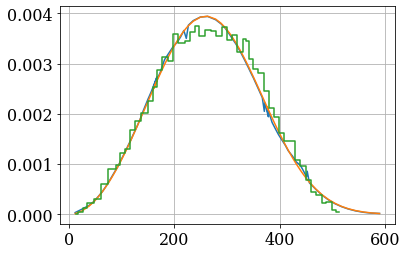

In [71]:
plt.plot(lingvs,lingps)
plt.plot(lingvs, gen_max(lingvs, 297.8, 1.5))
plt.step(lingvs_hist,lingps_hist,where='mid')

lingvs_hist/=lingsig
lingps_hist*=lingsig
res_ling=scipy.optimize.curve_fit(gen_max,lingvs_hist,lingps_hist)
print(res_ling)
v0_fit_ling, a_fit_ling = res_ling

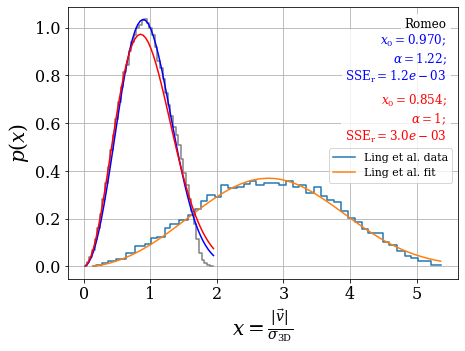

In [72]:
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
ax.step(lingvs_hist,lingps_hist,where='mid',
        label='Ling et al. data')
ax.plot(lingvs_hist, gen_max(lingvs_hist,*res_ling[0]),
        label='Ling et al. fit')
ax.legend(fontsize=11.,bbox_to_anchor=(0.999,0.5),loc='upper right')
fit_gal('Romeo',ax)
ax.set_ylabel('$p(x)$')
ax.set_xlabel('$x=\\frac{|\\vec{v}|}{\sigma_\mathrm{3D}}$')
fig.patch.set_facecolor('white')
plt.show()



### Muti-dimensional

#### Defining fitting method

In [89]:
def fit_dim_gal(galname, dim, pdf_dict, ax, trunc=False, trunc_max=trunc_max):
    bins=pdf_dict[galname][dim]['bins']
    xs=(bins[1:]+bins[:-1])/2.
    xs_fit_plt = np.linspace(xs.min(),xs.max(),int(1e3))
    ys=pdf_dict[galname][dim]['ps']
    
    if dim=='mag':
        if trunc:
            res_gen, _ = scipy.optimize.curve_fit(trunc_max, xs, ys,
                                                  p0=[3.,1.,6.])
            v0_gen, a_gen, vesc_gen = res_gen
            ys_fit_gen = trunc_max(xs,*res_gen)
            ys_fit_gen_plt = trunc_max(xs_fit_plt,*res_gen)

            maxwell = lambda xs,v0: gen_max(xs,v0,1.)
            res, _ = scipy.optimize.curve_fit(maxwell, xs, ys)
            v0 = res[0]
            ys_fit = maxwell(xs,v0)
            ys_fit_plt = maxwell(xs_fit_plt,v0)
        else:
            res_gen, _ = scipy.optimize.curve_fit(gen_max, xs, ys,
                                                  p0=[3.,1.])
            v0_gen, a_gen, = res_gen
            ys_fit_gen = gen_max(xs,*res_gen)
            ys_fit_gen_plt = gen_max(xs_fit_plt,*res_gen)

            maxwell = lambda xs,v0: gen_max(xs,v0,1.)
            res, _ = scipy.optimize.curve_fit(maxwell, xs, ys)
            v0 = res[0]
            ys_fit = maxwell(xs,v0)
            ys_fit_plt = maxwell(xs_fit_plt,v0)
    elif dim in ['x','y','z']:
        p=Parameters()
        p.add('mu',value=0.,vary=False,min=-1.,max=1.,brute_step=0.01)
        p.add('x0',value=1.,vary=True,min=1e-6,max=6.,brute_step=0.01)
        p.add('a',value=1.,vary=True,min=-20.,max=20.)
        
        def errs_gen_gauss(p,xs,ys_data):
            mu=p['mu'].value
            x0=p['x0'].value
            a=p['a'].value
            ys_fit=gen_gauss(xs,mu,x0,a)
            errs=ys_data-ys_fit
            return errs
        
        res_min = minimize(errs_gen_gauss, p, args=(xs,ys),
                           method='lm')
        res_gen = [res_min.params[key].value for key in res_min.params]
        mu_gen, v0_gen, a_gen = res_gen
        ys_fit_gen = gen_gauss(xs,*res_gen)
        ys_fit_gen_plt = gen_gauss(xs_fit_plt,*res_gen)
    
        gauss = lambda xs,mu,v0: gen_gauss(xs,mu,v0,1.)
        res, _ = scipy.optimize.curve_fit(gauss, xs, ys)
        mu, v0 = res
        ys_fit = gauss(xs,*res)
        ys_fit_plt = gauss(xs_fit_plt,*res)
    else:
        raise ValueError('dim must be \'x\' \'y\' \'z\' \'mag\' or \'magtrunc\'')
    
    sse_gen = np.sum((ys-ys_fit_gen)**2.) #SSE for generalized distribution
    sser_gen=sse_gen/(xs.size-len(res_gen))    
    sse_1=np.sum((ys-ys_fit)**2.)
    sser_1=sse_1/(xs.size-len(res))
    
    ax.step(xs,ys,'k',where='mid',color='grey')
    ax.plot(xs_fit_plt,ys_fit_gen_plt,'-',color='b',lw=2.)
    ax.plot(xs_fit_plt,ys_fit_plt,'-',color='red')
    
    loc=[1.,.983]
    
    kwargs_txt = dict(fontsize=12., xycoords='axes fraction',
                  va='top', ha='right', 
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    if dim=='mag':
        if trunc:
            ax.annotate(galname,loc,
                        **kwargs_txt)
            txt_gen = '$\\xi_0={0:0.2f};$\n$\\alpha={1:0.2f};$\n'\
                      '$\\xi_\mathrm{{esc}}={3:0.1f}$\n'\
                      '$\mathrm{{SSE}}_\mathrm{{r}}={2:0.1e}$'.format(v0_gen,a_gen,sser_gen,vesc_gen)
            inv = ax.transAxes.inverted()
            loc=ax.transAxes.transform(loc)
            loc[1]-=17.
            loc=inv.transform(loc)
            ax.annotate(txt_gen, loc, color='b',
                        **kwargs_txt)
            txt_1 = '$\\xi_0={0:0.3f};$\n$\\alpha=1;$\n$\mathrm{{SSE}}_\mathrm{{r}}={1:0.1e}$'.format(v0,sser_1)
            loc=ax.transAxes.transform(loc)
            loc[1]-=75.
            loc=inv.transform(loc)
            ax.annotate(txt_1, loc,
                        color='r',
                        **kwargs_txt)          
        else:
            ax.annotate(galname,loc,
                        **kwargs_txt)
            txt_gen = '$\\xi_0={0:0.2f};$\n$\\alpha={1:0.2f};$\n'\
                      '$\mathrm{{SSE}}_\mathrm{{r}}={2:0.1e}$'.format(v0_gen,a_gen,sser_gen)
            inv = ax.transAxes.inverted()
            loc=ax.transAxes.transform(loc)
            loc[1]-=17.
            loc=inv.transform(loc)
            ax.annotate(txt_gen, loc, color='b',
                        **kwargs_txt)
            txt_1 = '$\\xi_0={0:0.3f};$\n$\\alpha=1;$\n$\mathrm{{SSE}}_\mathrm{{r}}={1:0.1e}$'.format(v0,sser_1)
            loc=ax.transAxes.transform(loc)
            loc[1]-=55.
            loc=inv.transform(loc)
            ax.annotate(txt_1, loc,
                        color='r',
                        **kwargs_txt)        
    elif dim in ['x','y','z']:
        ax.annotate(galname,loc,
                    **kwargs_txt)
        inv = ax.transAxes.inverted()
        loc=ax.transAxes.transform(loc)
        loc[1]-=20.
        loc=inv.transform(loc)
        txt_gen = '$\mu={3:0.3f};$\n'\
                  '$\\xi_0={0:0.2f};$\n$\\alpha={1:0.2f};$\n'\
                  '$\mathrm{{SSE}}_\mathrm{{r}}={2:0.2e}$\n'\
                  .format(v0_gen,a_gen,sser_gen,mu_gen)
        ax.annotate(txt_gen, loc, color='b',
                    **kwargs_txt)
        txt_1 = '$\mu={2:0.3f};$\n'\
                '$\\xi_0={0:0.2f};$\n$\\alpha=1;$\n$\mathrm{{SSE}}_\mathrm{{r}}={1:0.2e}$'\
                .format(v0,sser_1,mu)
        loc=ax.transAxes.transform(loc)
        loc[1]-=75.
        loc=inv.transform(loc)
        ax.annotate(txt_1, loc,
                    color='r',
                    **kwargs_txt)
    return sser_gen, a_gen

#### Plotting

In [74]:
with open('./data/x_pdfs_20210823.pkl','rb') as f:
    dict_3d=pickle.load(f)

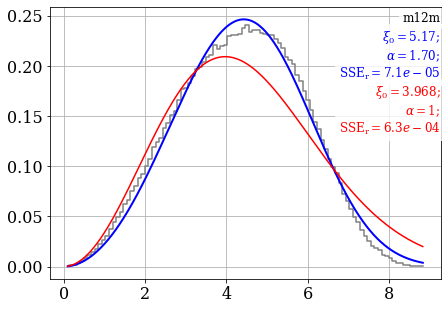

In [75]:
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
fit_dim_gal('m12m', 'mag', dict_3d, ax, trunc=False)
xs_test=np.linspace(0.,9.,int(1e3))
#ax.plot(xs_test,trunc_max(xs_test,5.171,1.7,8.),color='limegreen')
plt.show()

/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


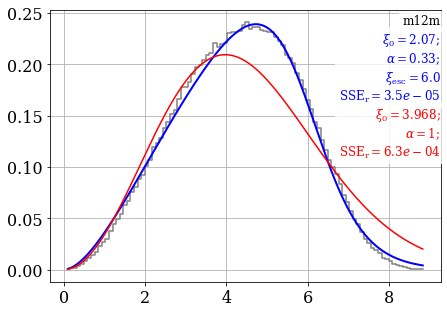

In [76]:
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
fit_dim_gal('m12m', 'mag', dict_3d, ax, trunc=True, trunc_max=exp_trunc_max)
xs_test=np.linspace(0.,9.,int(1e3))
#ax.plot(xs_test,trunc_max(xs_test,5.171,1.7,8.),color='limegreen')
plt.show()

In [158]:
def make_panels(dict_3d, sim_type):
    sses=pd.DataFrame()
    alphas=pd.DataFrame()
    for d,t in zip(['x','y','z','mag','mag'],
                   [False,False,False,False,True]):
        ismag = d=='mag'
        isdim = d in ['x','y','z']
        fig,axs=plt.subplots(3,5,figsize=(20.*1.3,12.*1.3),sharey=True,
                             sharex=True)
        axs=axs.ravel()
        fig.subplots_adjust(wspace=0.,hspace=0.)
        if t:
            col=d+'_trunc'
            trunc_title=', truncated'
        else:
            col=d
            trunc_title=''
        for i,galname in enumerate(dict_3d):
            res = fit_dim_gal(galname,d,dict_3d,axs[i],trunc=t, 
                              trunc_max=exp_trunc_max)
            sses.loc[galname,col], alphas.loc[galname,col] = res
        #axs[-1].xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
        if ismag:
            axs[-1].set_xlim(0.,9.)
        elif isdim:
            axs[-1].set_xlim(-4,4.)
        else:
            raise ValueError
        for axi in [0,5,10]:
            axs[axi].set_ylabel('$p(\\xi)$')
        for axi in range(10,15):
            if ismag:
                axs[axi].set_xlabel('$\\xi=\\frac{|\\vec{v}|}{\sigma_{|\\vec{v}|}}$')
            elif isdim:
                axs[axi].set_xlabel('$\\xi=\\frac{{\\vec{{v}}\cdot\hat{0:s}}}{{\sigma_{0:s}}}$'.format(d))
            else:
                raise ValueError
        fig.patch.set_facecolor('white')
        if d in ['x','y','z']:
            veltitle = '$\\vec{{v}}\cdot\hat{0:s}$'.format(d)
        elif d=='mag':
            veltitle = '$|\\vec{v}|$'
        fig.suptitle('{0:s}, {1:s}{2:s}'.format(sim_type, veltitle, 
                                                trunc_title), 
                     y=0.91,
                     fontsize=23.)
        plt.plot()
    return sses,alphas

##### FIRE

/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/li

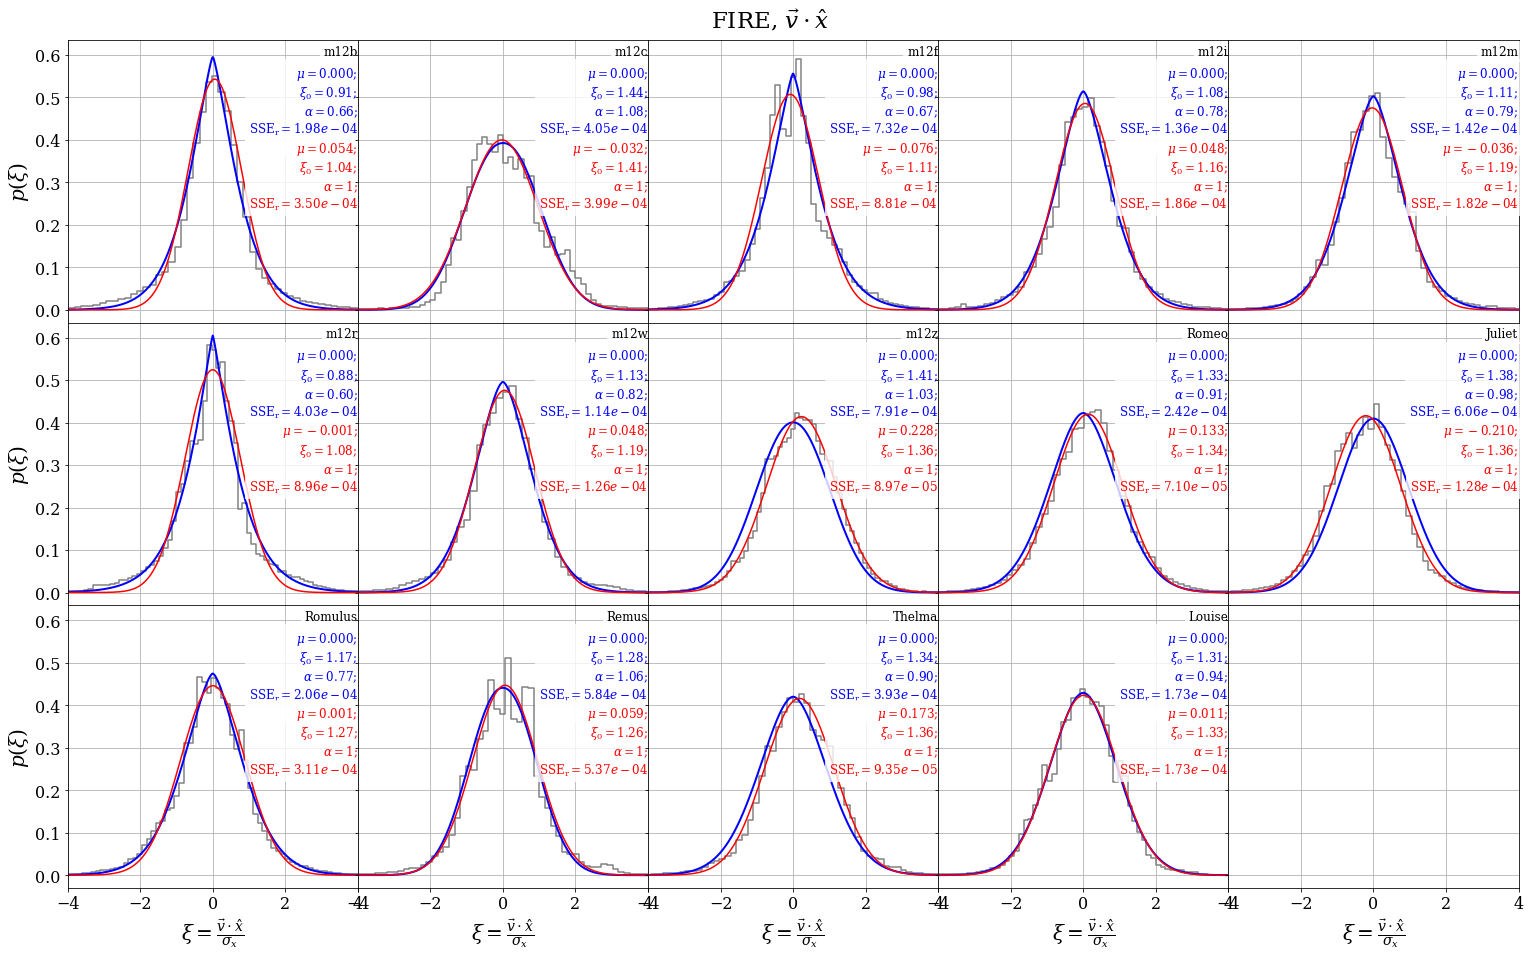

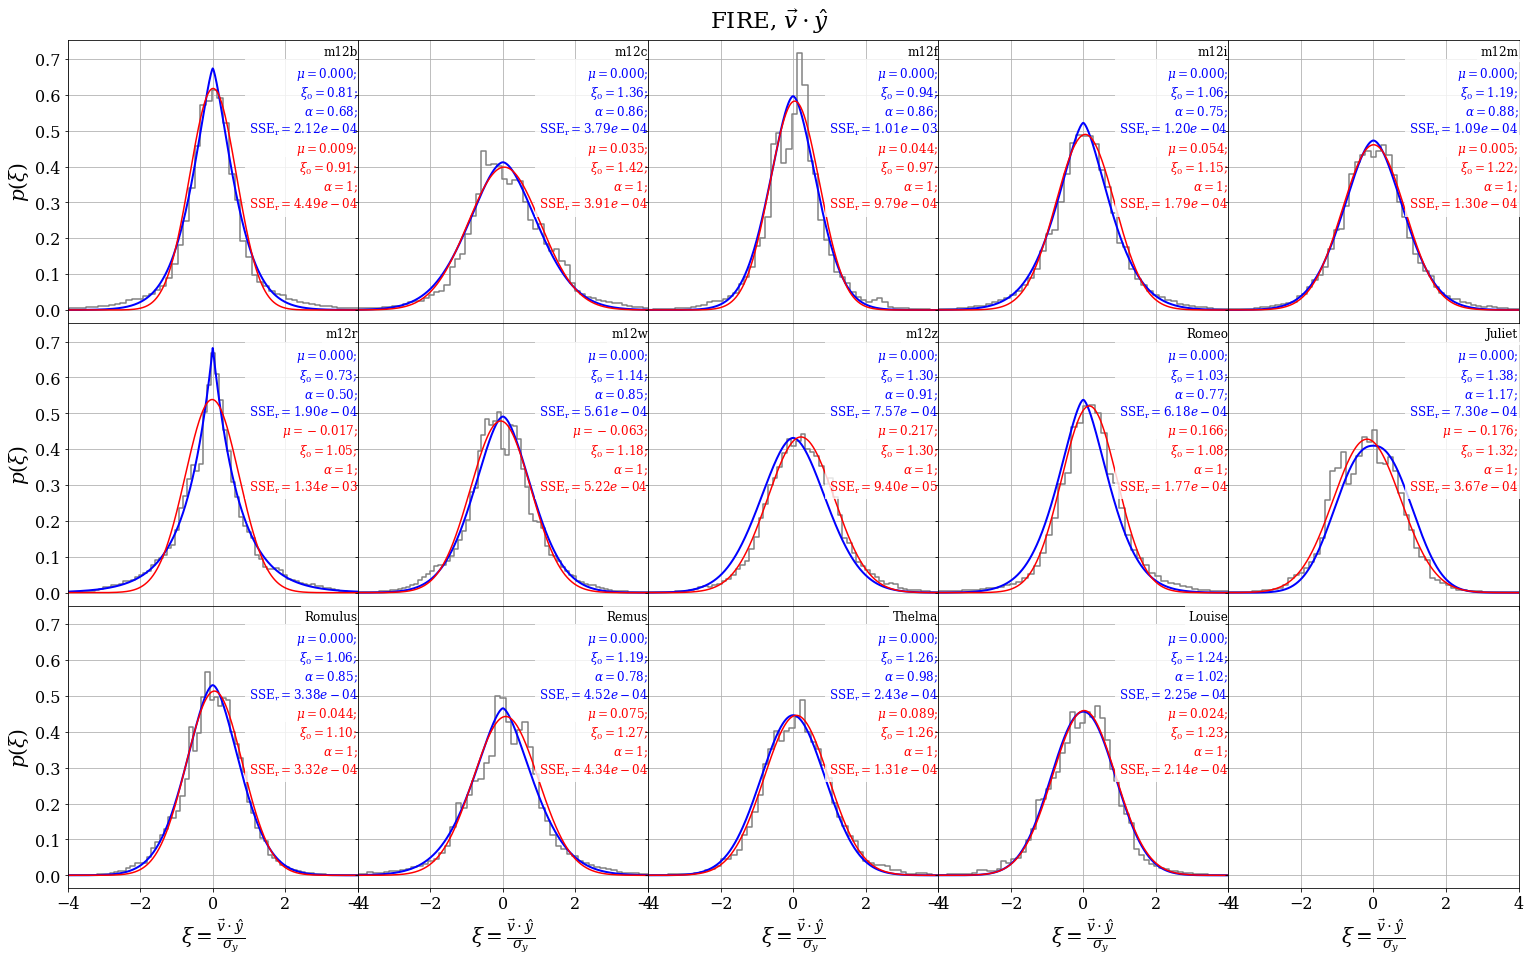

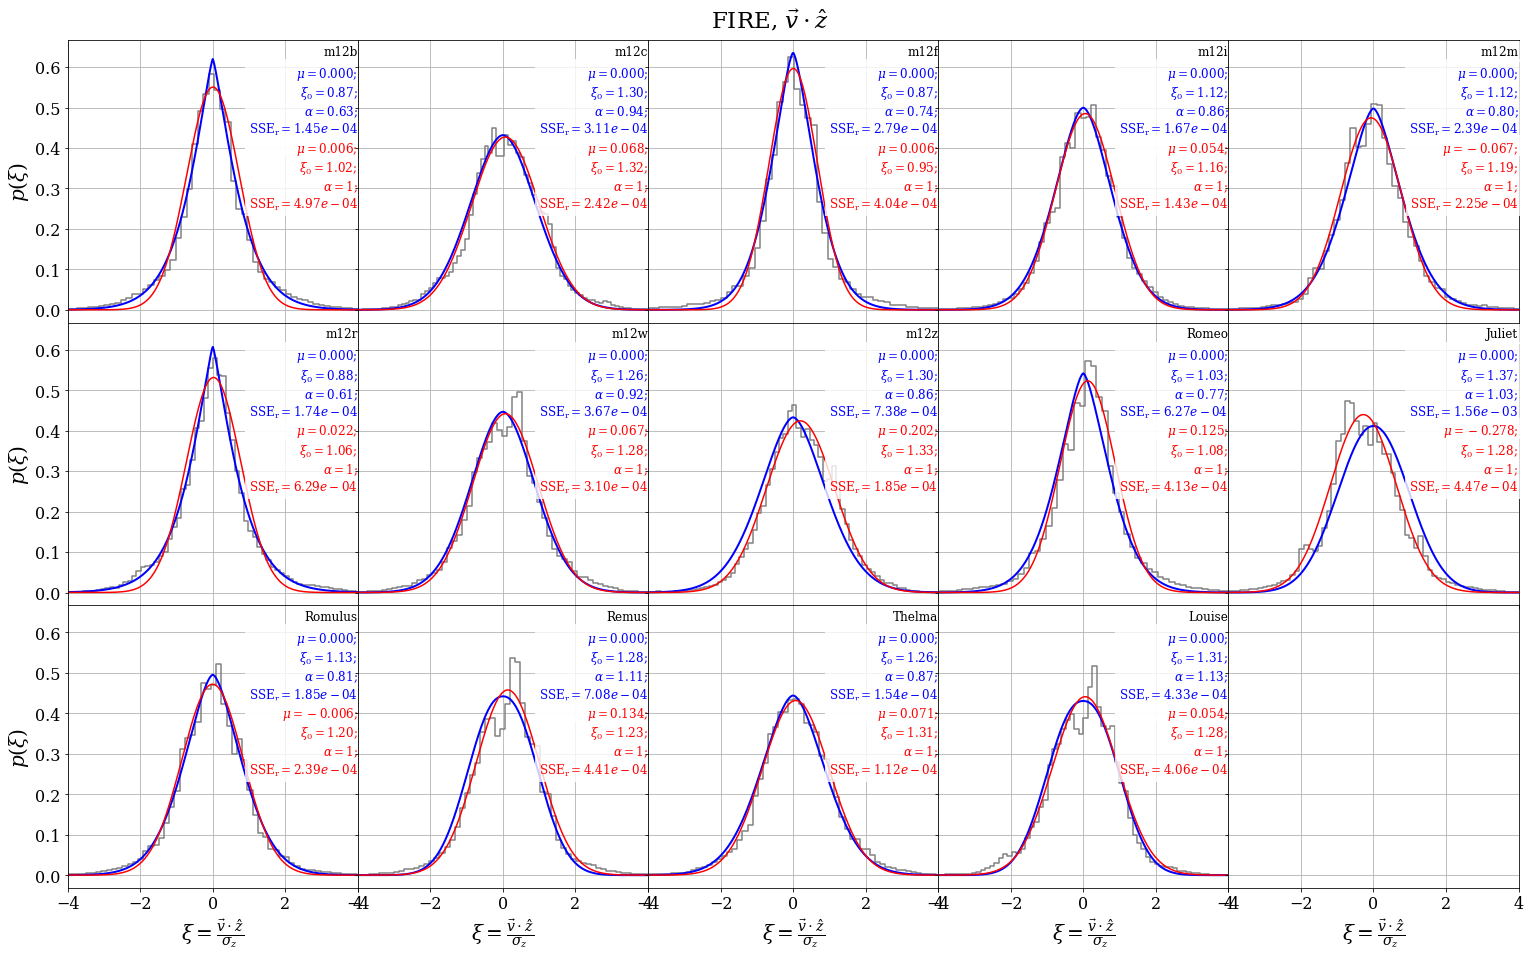

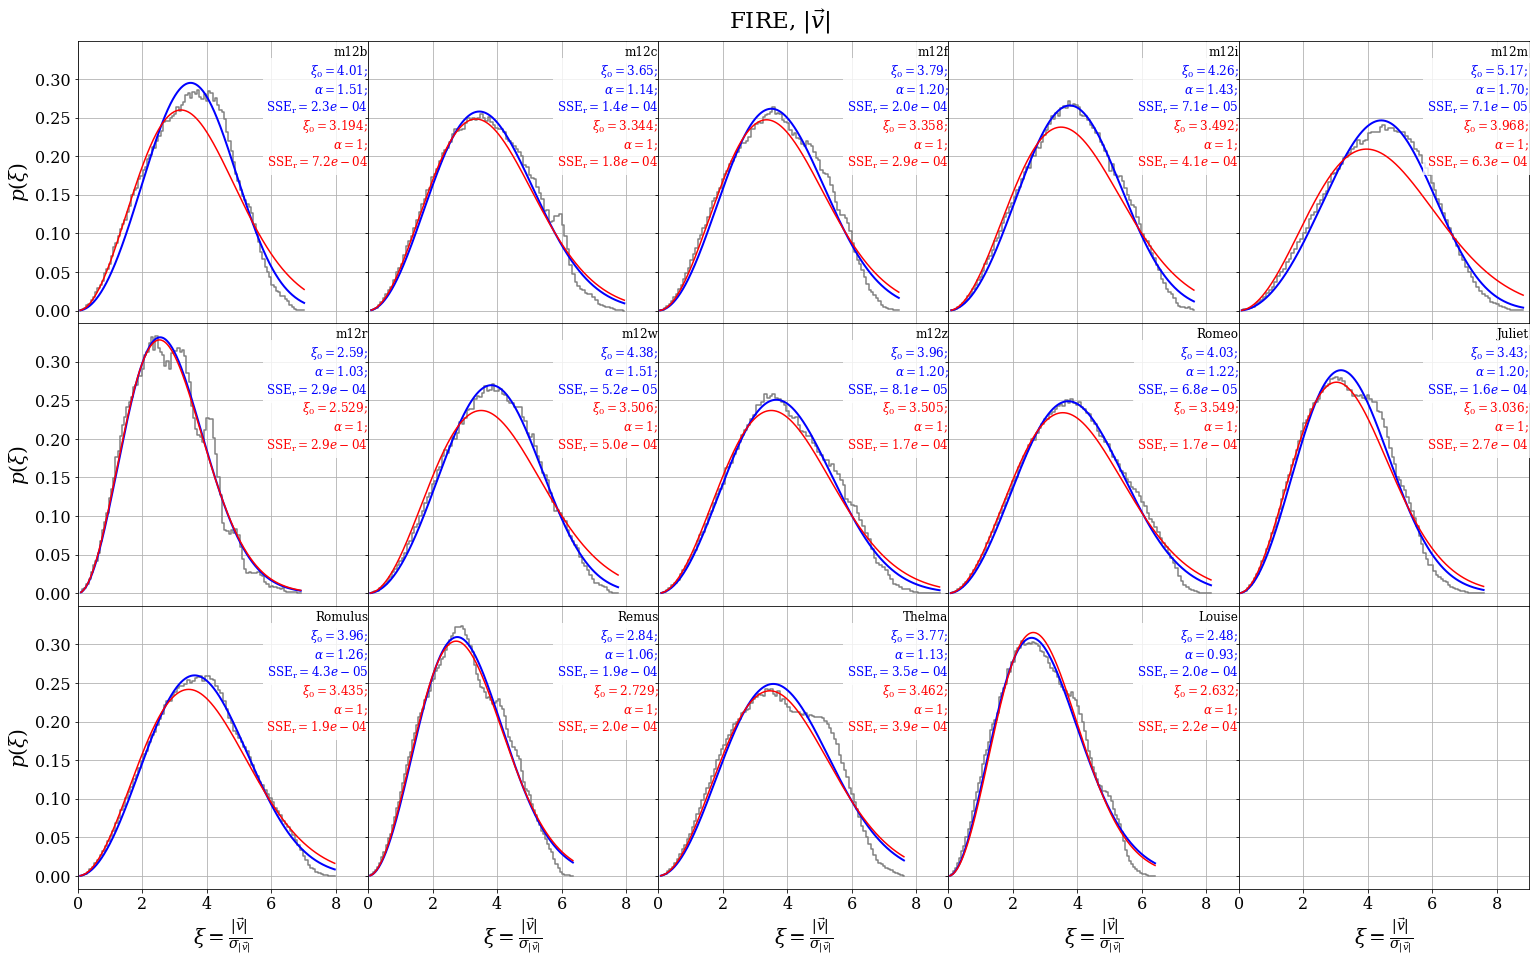

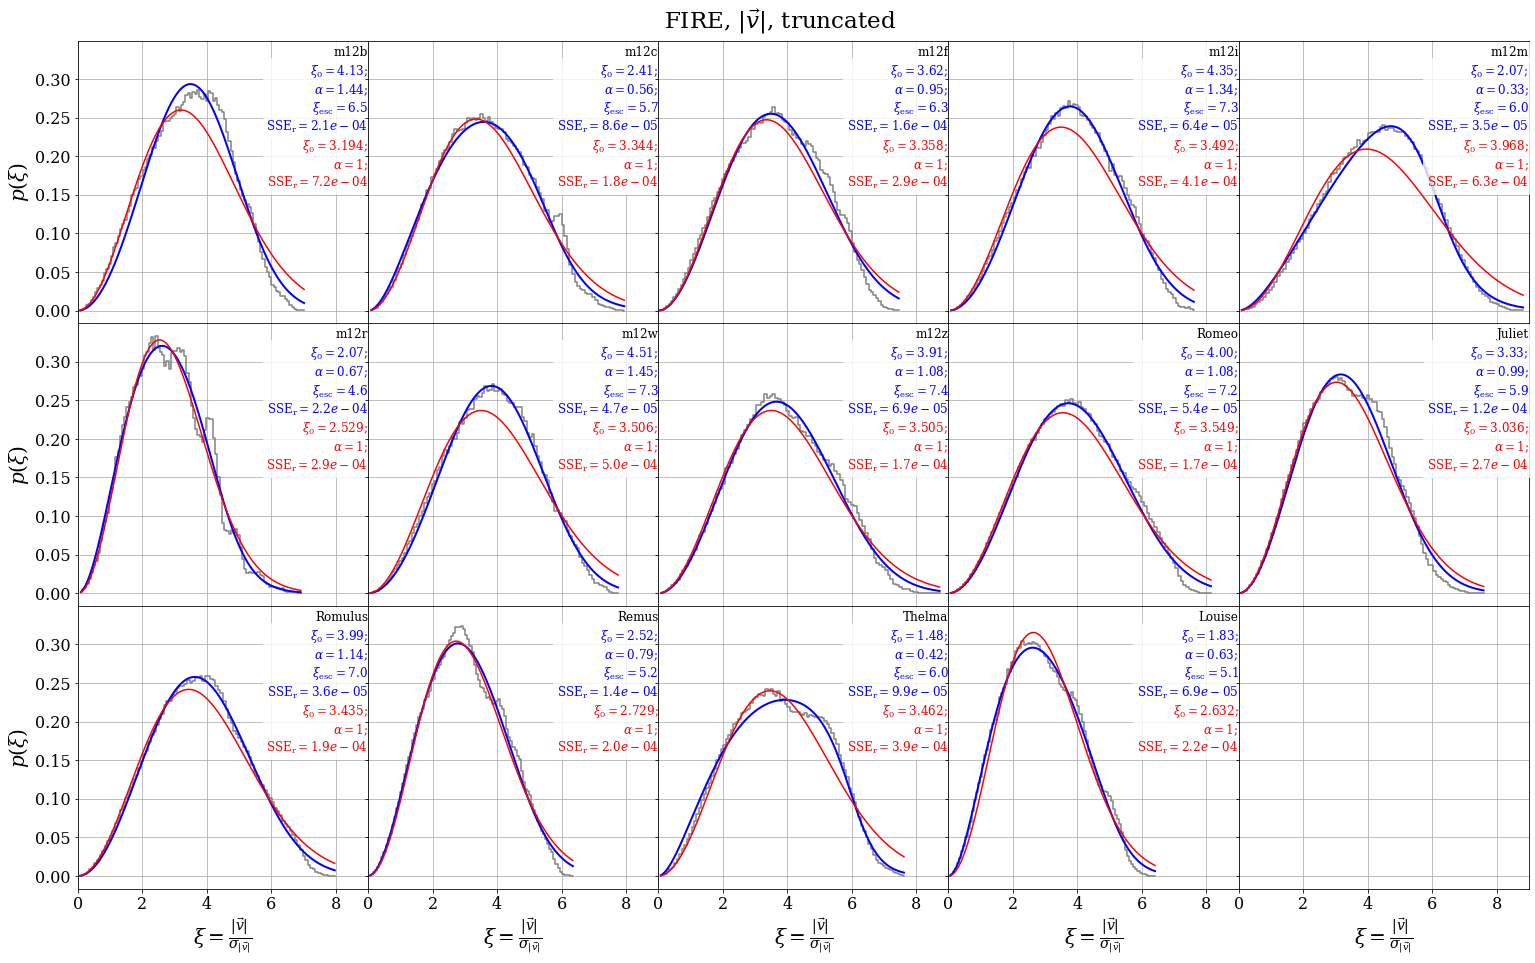

In [159]:
sses_fire, alphas_fire = make_panels(dict_3d, 'FIRE')

##### DMO

/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/nfspool-0/home/pstaudt/envs/project01/li

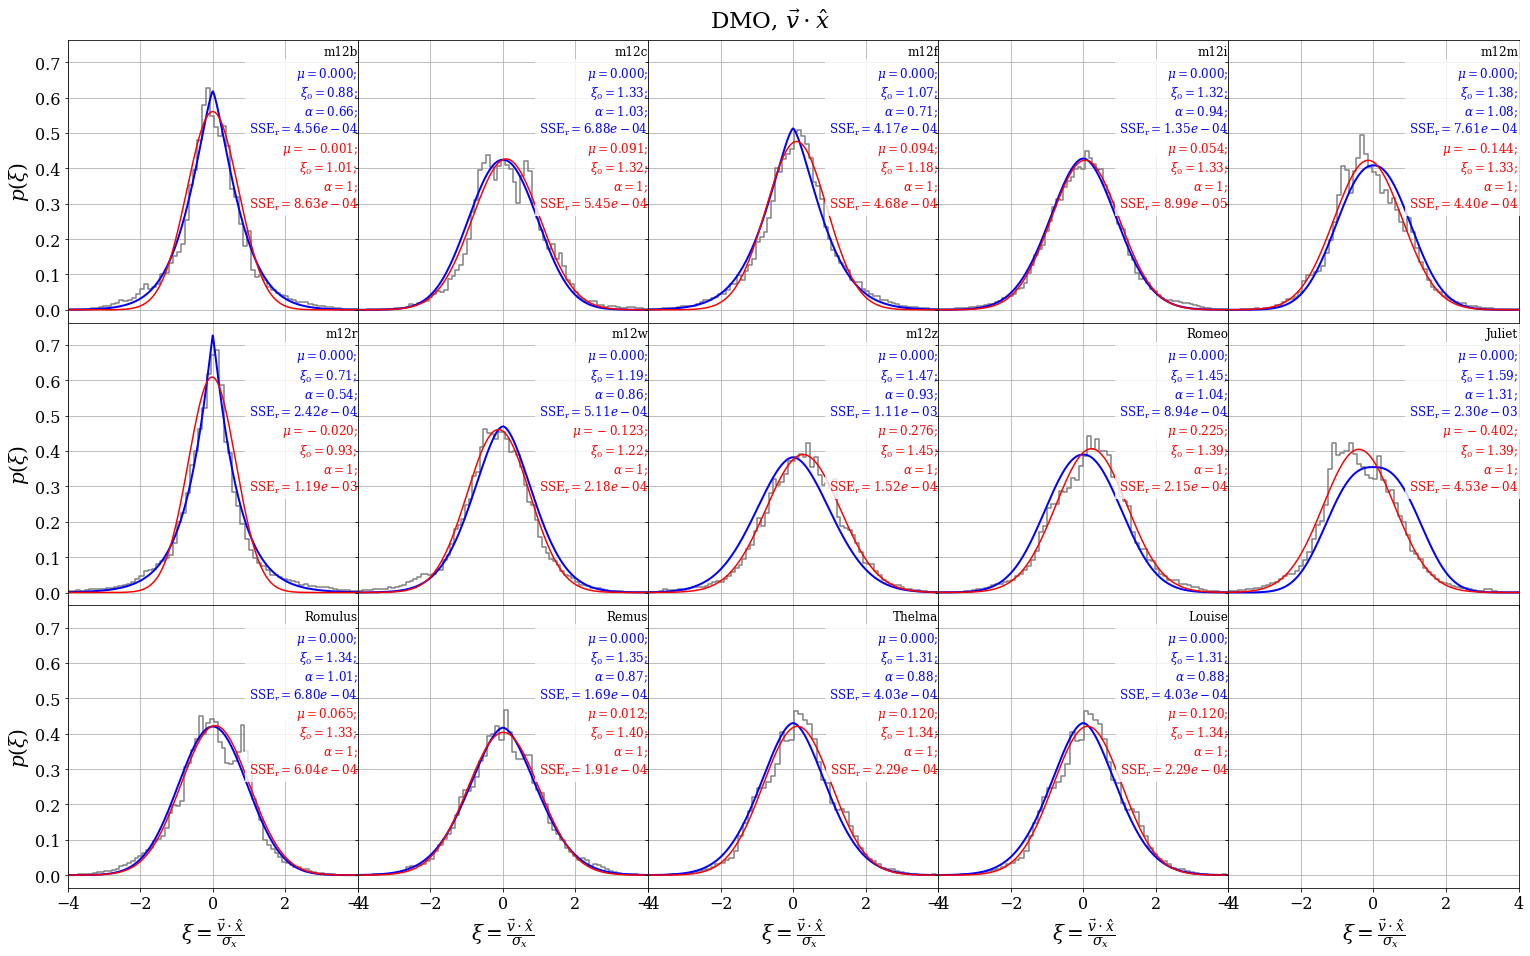

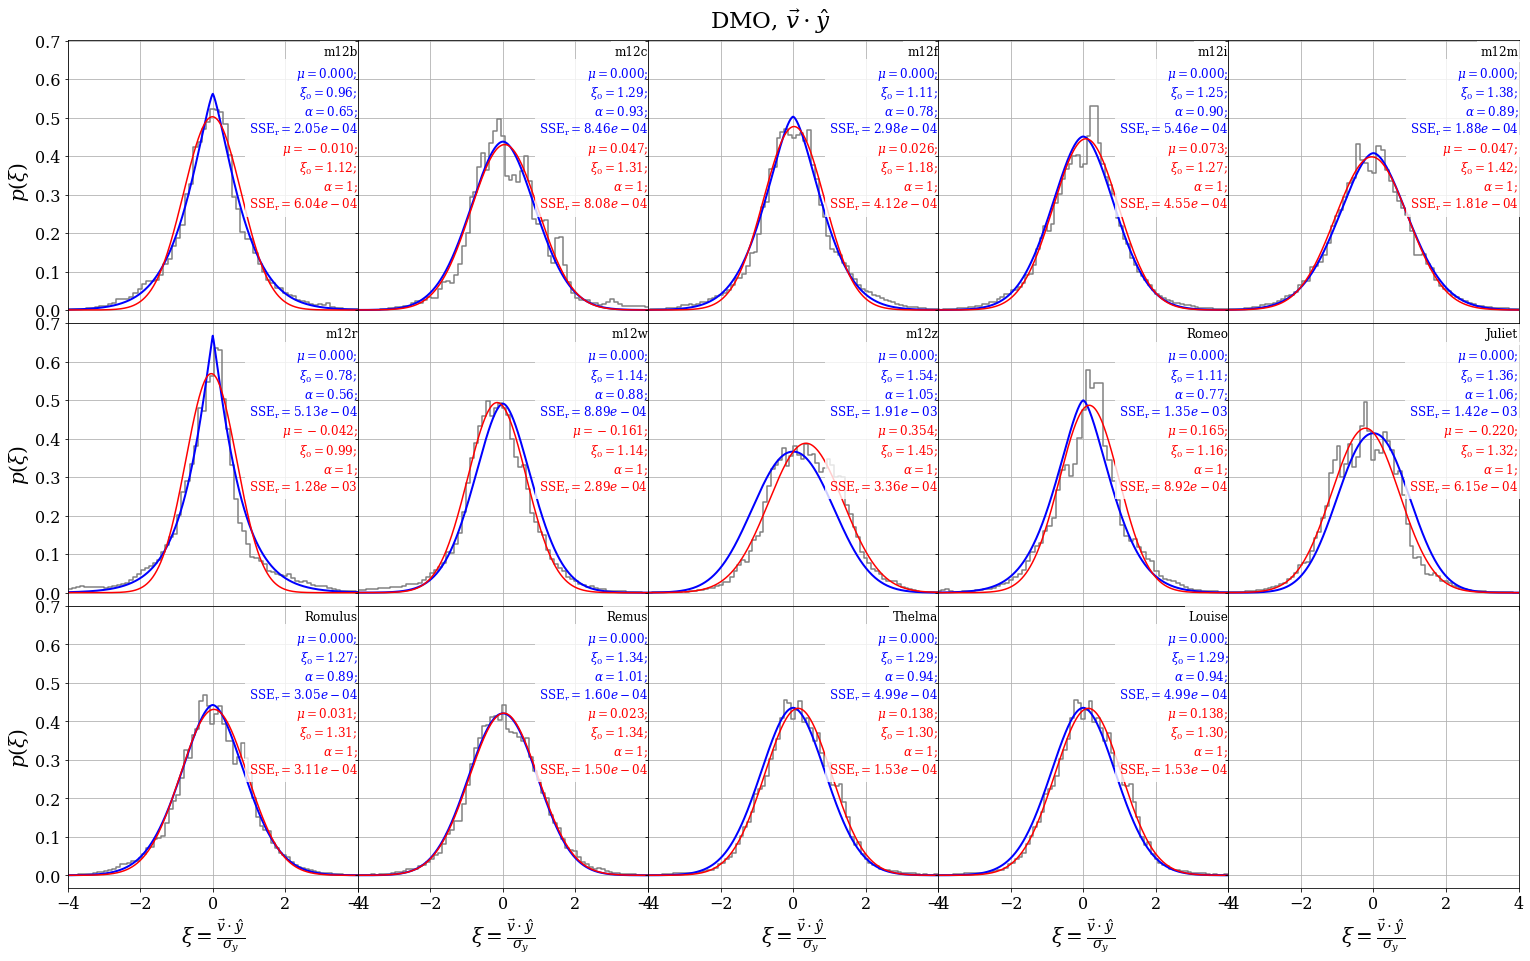

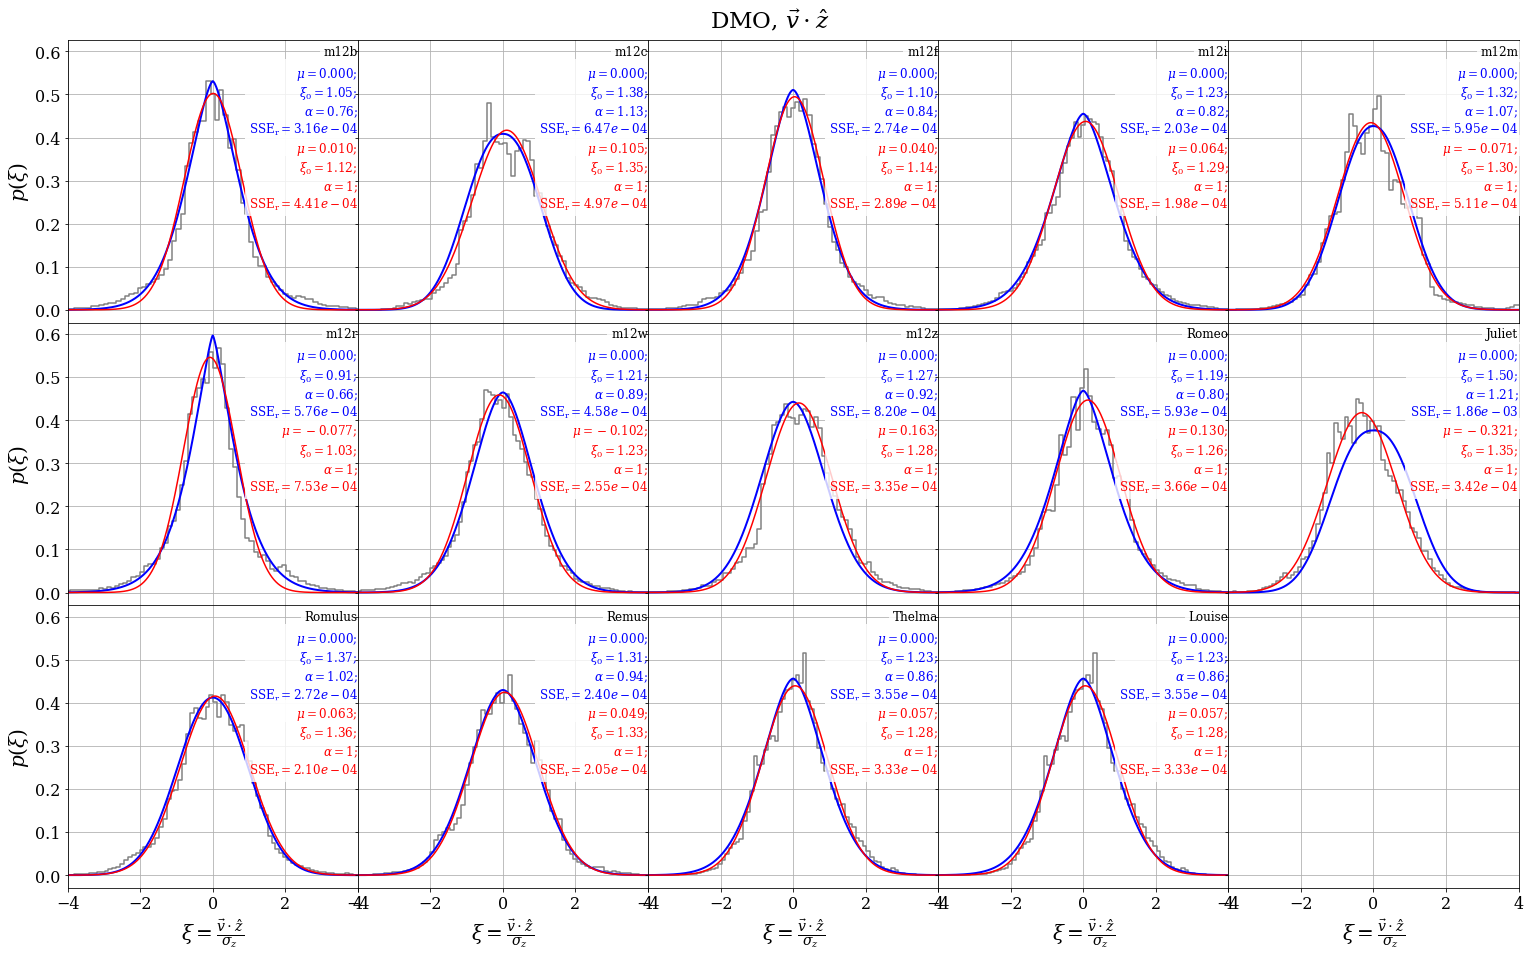

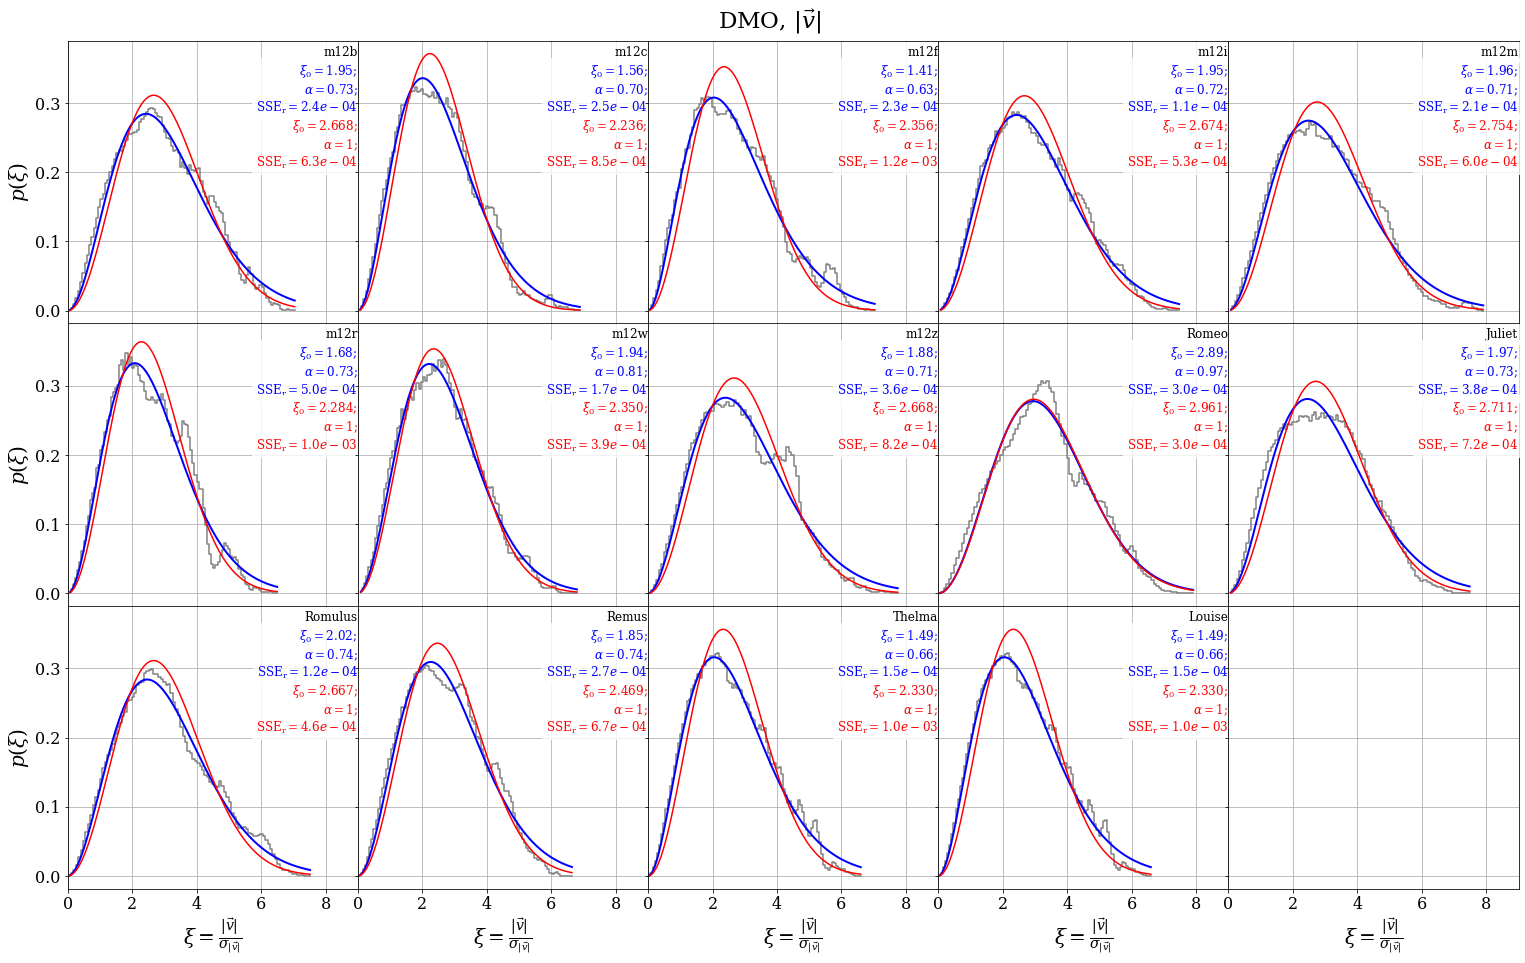

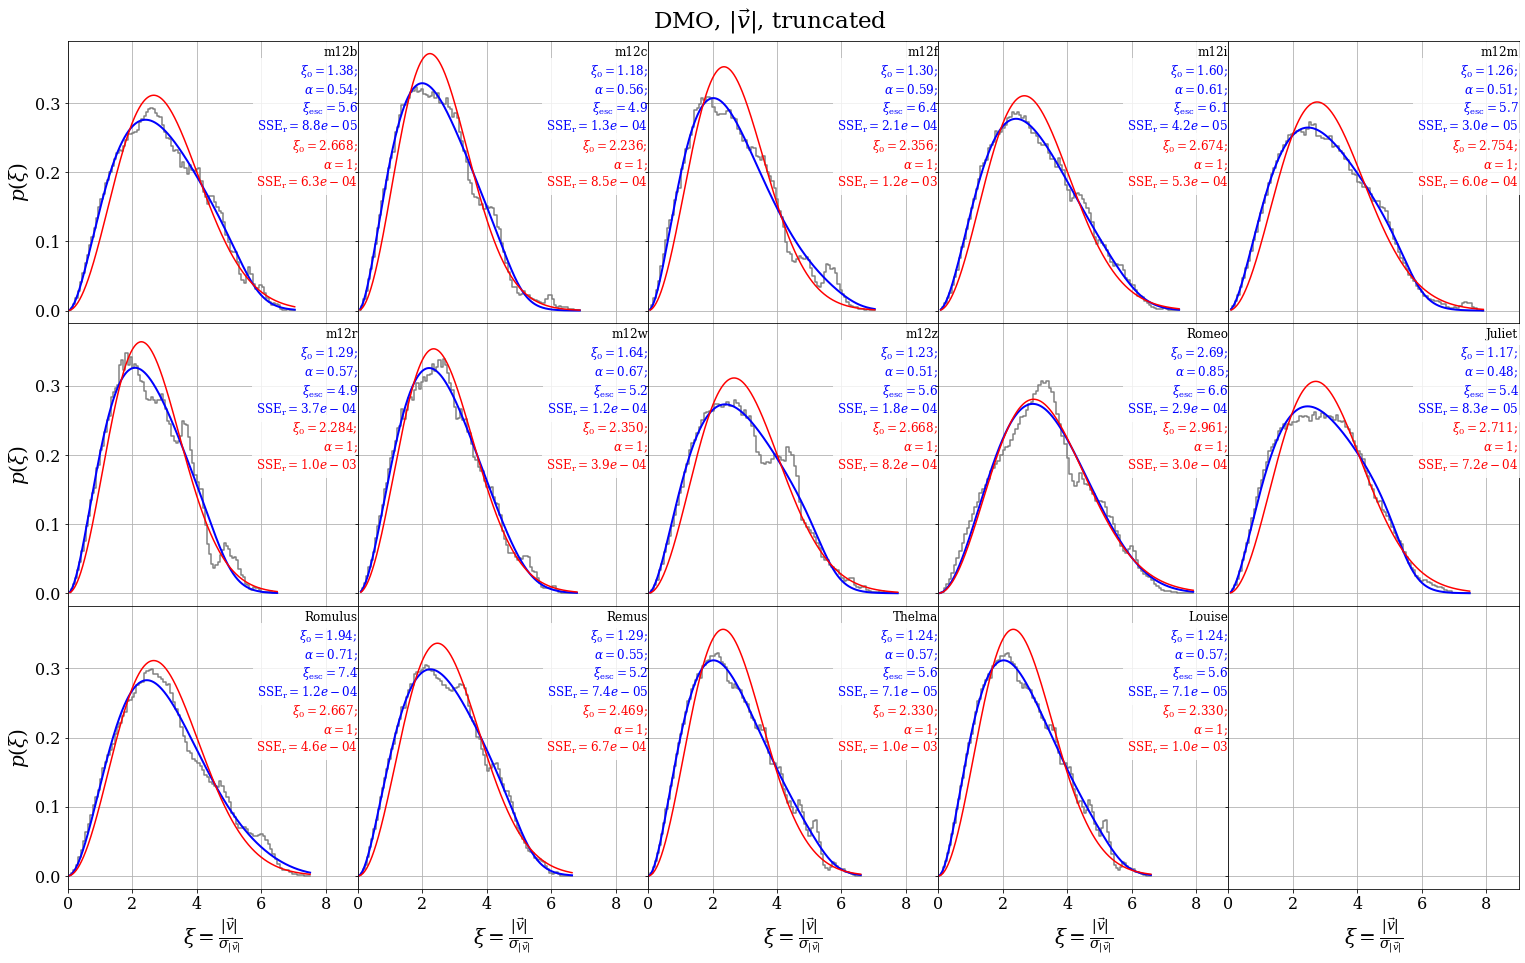

In [160]:
with open('./data/x_pdfs_dmo_20210907.pkl','rb') as f:
    dict_3d_dmo=pickle.load(f)
sses_dmo, alphas_dmo = make_panels(dict_3d_dmo, 'DMO')

##### Comparing

In [227]:
def comp_fire_dmo(df_fire, df_dmo, metric):
    metric=metric.lower()
    assert metric in ['sse','alpha']
    fig,axs=plt.subplots(2,2,figsize=(20,9),sharey=True,
                         sharex=True)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)

    lw_dmo=3.
    if metric=='sse':
        scale=1.e3
        #title='SSE'
    else:
        scale=1.
    for i,d in enumerate(['x','y','z','mag_trunc']):
        if i==0:
            _,bins,_ = axs[i].hist(df_dmo[d]*scale, bins=8, histtype='step', 
                                   lw=lw_dmo, label='dmo')
        else:
            axs[i].hist(df_dmo[d]*scale, bins=bins, histtype='step', lw=lw_dmo,
                        label='dmo')
        axs[i].hist(df_fire[d]*scale, bins=bins, histtype='step', lw=2, 
                    label='fire')
        
        if i in [0,2]:
            axs[i].set_ylabel('$N_\mathrm{gal}$')
        if i in [2,3]:
            if metric=='sse':
                axs[i].set_xlabel('SSE / df $\\times10^3$')
            elif metric=='alpha':
                axs[i].set_xlabel('$\\alpha$')
        if i==1:
            axs[i].legend()
        kwargs_txt = dict(fontsize=22., xycoords='axes fraction',
                          va='top', ha='right', 
                          bbox=dict(facecolor='white', alpha=.9, 
                          edgecolor='none'), xy=(0.95,0.65))
        if d in ['x','y','z']:
            axs[i].annotate('$\\vec{{v}}\cdot\\hat{0:s}$'.format(d),
                            color='k',
                            **kwargs_txt)
        elif d=='mag_trunc':
            axs[i].annotate('$|\\vec{v}|$', 
                            color='k',
                            **kwargs_txt)
            
    #fig.suptitle(title, y=0.92, fontsize=20.)        
    
    plt.show()

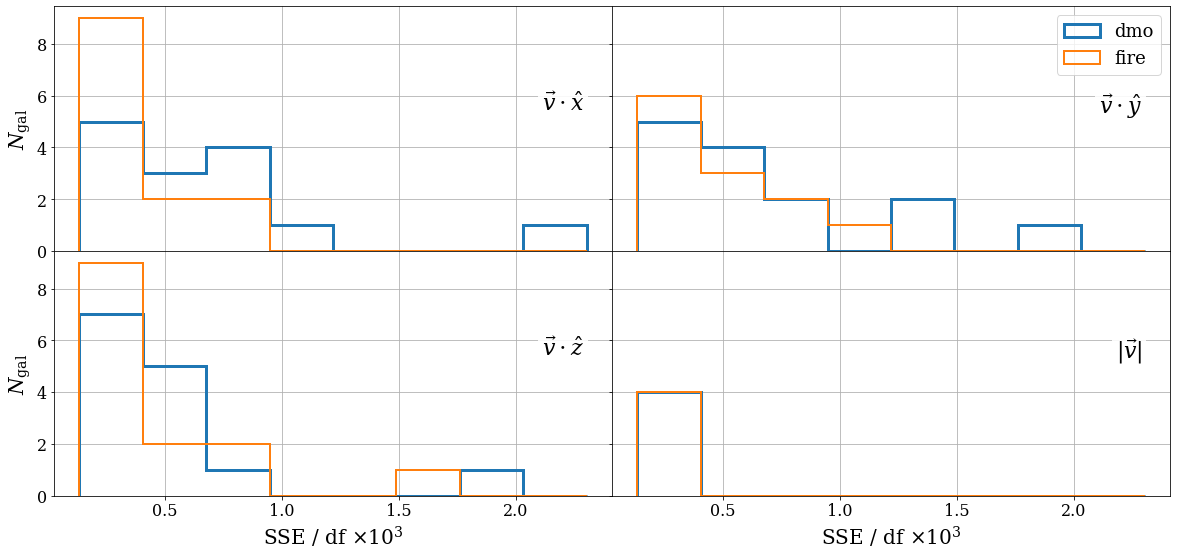

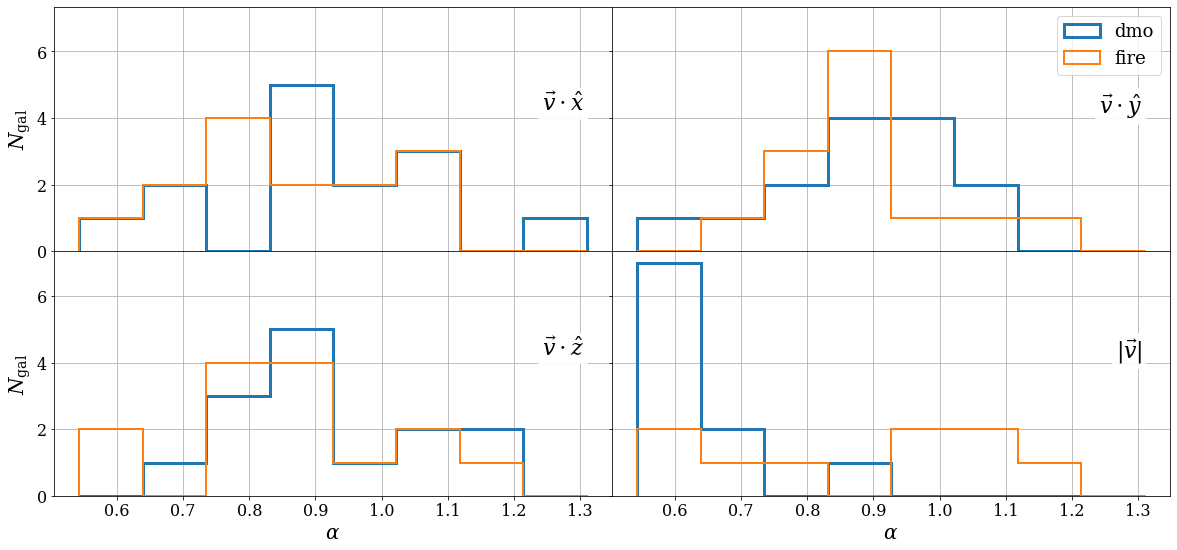

In [228]:
comp_fire_dmo(sses_fire, sses_dmo, 'sse')
comp_fire_dmo(alphas_fire, alphas_dmo, 'alpha')